## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
%load_ext lab_black
from src.perspective import Calibration
import glob
import cv2
import numpy as np

test model calibration

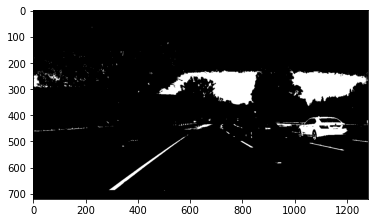

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image = mpimg.imread("test_images/test6.jpg")
thresh = (180, 255)
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
binary1 = np.zeros_like(gray)
binary1[(gray > thresh[0]) & (gray <= thresh[1])] = 1
plt.imshow(binary1, cmap="gray")

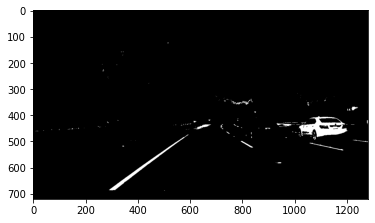

In [3]:
R = image[:, :, 0]
G = image[:, :, 1]
B = image[:, :, 2]

thresh = (200, 255)
binary2 = np.zeros_like(R)
binary2[(R > thresh[0]) & (R <= thresh[1])] = 1
plt.imshow(binary2, cmap="gray")

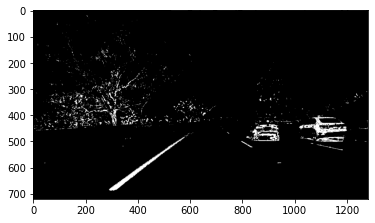

In [4]:
hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
H = hls[:, :, 0]
L = hls[:, :, 1]
S = hls[:, :, 2]

thresh = (150, 255)
binary3 = np.zeros_like(S)
binary3[(S > thresh[0]) & (S <= thresh[1])] = 1
plt.imshow(binary3, cmap="gray")

In [5]:
from src.perspective import Calibration
from src.line import LaneDetection
from src.filters import ColorFiltering, GradientFiltering, MorphologyFiltering
from src.annotate import AnnotateFrame
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob


def process_frame(
    img,
    gradient_params,
    color_params,
    morph_params,
    lane_detect_params,
    annotate_params,
):
    """ pipeline that process and annotate a single frame """
    # apply color filters
    color = ColorFiltering(**color_params)
    color_filtered_img = color.apply_color_filter(img)

    # apply gradient filters
    gradient = GradientFiltering(**gradient_params)
    gradient_filtered_img = gradient.apply_gradient_filter(img)

    # combine gradient and color filter
    combined_filtered_image = np.logical_or(color_filtered_img, gradient_filtered_img)

    # apply morphology filter
    morph = MorphologyFiltering(**morph_params)
    combined_filtered_image2 = morph.apply_morphology_filter(combined_filtered_image)

    # calibrate the carmera
    perspective_transformer = Calibration()
    perspective_transformer.set_calibration()
    # undistort and convert image to bird's eye view
    birdeye_filtered_img = perspective_transformer.undistort_and_birdeye_transform(
        combined_filtered_image2
    )
    birdeye_original_img = perspective_transformer.undistort_and_birdeye_transform(img)

    # detect lanes
    left_lane, right_lane = LaneDetection(
        img=birdeye_filtered_img, **lane_detect_params
    ).detect()
    return (
        color_filtered_img,
        gradient_filtered_img,
        combined_filtered_image,
        combined_filtered_image2,
        birdeye_filtered_img,
        birdeye_original_img,
        left_lane,
        right_lane,
    )

## And so on and so forth...

In [6]:
test_img = glob.glob("test_images/*.jpg")[6]
img = cv2.imread(test_img)
(
    color_filtered_img,
    gradient_filtered_img,
    combined_filtered_image,
    combined_filtered_image2,
    birdeye_filtered_img,
    birdeye_original_img,
    left_lane,
    right_lane,
) = process_frame(
    img,
    gradient_params=dict(
        sobel_kernel_size=3,
        sobel_threshold=(20, 100),
        magnitude_threshold=(50, 255),
        direction_threshold=(0.7, 1.3),
    ),
    color_params=dict(s_thresholds=(150, 255), r_thresholds=(200, 255)),
    morph_params=dict(kernel_size=(5, 5)),
    lane_detect_params=dict(
        num_windows=9,
        window_margin=50,
        min_pixels=50,
        fit_tolerance=100,
        cache_size=15,
    ),
    annotate_params=dict(
        line_width=50,
        lane_color=(255, 0, 0),
        road_region_color=(0, 255, 0),
    ),
)

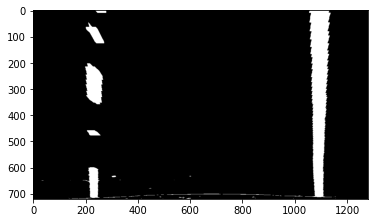

In [7]:
plt.imshow(birdeye_filtered_img, cmap="gray")

In [13]:
right_lane.recent_fitted_coeffs_in_meters

[array([-1.31051433e-05, -7.01975851e-04,  5.79078686e+00])]

In [9]:
test_img = glob.glob("test_images/*.jpg")[3]
img = cv2.imread(test_img)
hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
H = hls[:, :, 0]
L = hls[:, :, 1]
S = hls[:, :, 2]
thresh = (90, 255)
binary = np.zeros_like(S)
binary[(S > thresh[0]) & (S <= thresh[1])] = 1

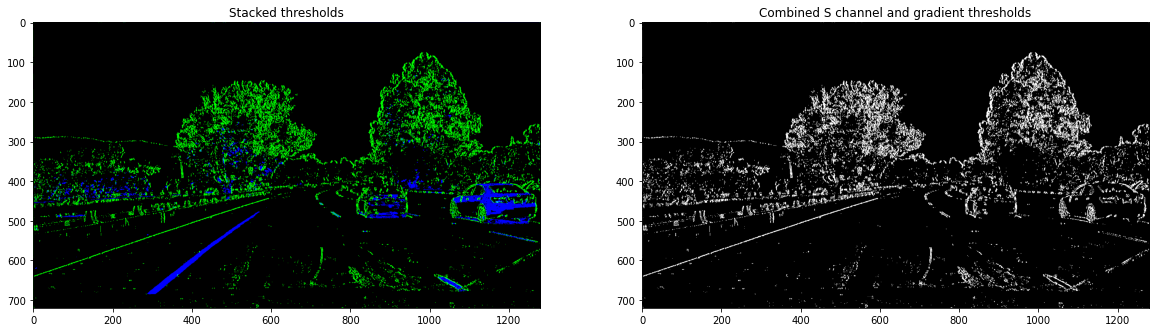

In [10]:
# Convert to HLS color space and separate the S channel
# Note: img is the undistorted image
hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
s_channel = hls[:, :, 2]

# Grayscale image
# NOTE: we already saw that standard grayscaling lost color information for the lane lines
# Explore gradients in other colors spaces / color channels to see what might work better
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Sobel x
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)  # Take the derivative in x
abs_sobelx = np.absolute(
    sobelx
)  # Absolute x derivative to accentuate lines away from horizontal
scaled_sobel = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))

# Threshold x gradient
thresh_min = 20
thresh_max = 100
sxbinary = np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

# Threshold color channel
s_thresh_min = 170
s_thresh_max = 255
s_binary = np.zeros_like(s_channel)
s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

# Stack each channel to view their individual contributions in green and blue respectively
# This returns a stack of the two binary images, whose components you can see as different colors
color_binary = np.dstack((np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

# Combine the two binary thresholds
combined_binary = np.zeros_like(sxbinary)
combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.set_title("Stacked thresholds")
ax1.imshow(color_binary)

ax2.set_title("Combined S channel and gradient thresholds")
ax2.imshow(sxbinary, cmap="gray")

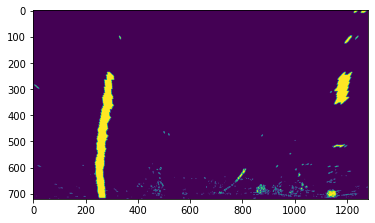

In [11]:
plt.imshow(Calibration().undistort_and_birdeye_transform(combined_binary))